In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torchinfo


# test hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Download Dataset

In [21]:
train_ds = torchvision.datasets.MNIST('data', 
                                      train=True, 
                                      transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                      download=True)

test_ds  = torchvision.datasets.MNIST('data', 
                                      train=False, 
                                      transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                      download=True)

In [22]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True)

test_dl  = torch.utils.data.DataLoader(test_ds, 
                                       batch_size=batch_size)

In [23]:
# read a batch of data
# Data shape：[batch_size, channel, height, weight]

imgs, labels = next(iter(train_dl))
imgs.shape

torch.Size([32, 1, 28, 28])

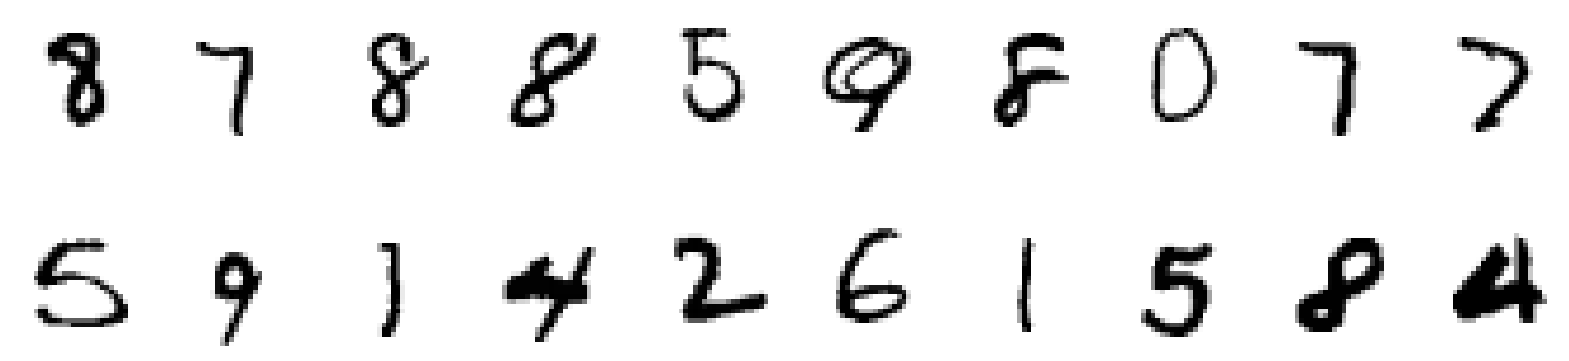

In [24]:


 # set the figure size to 20 inch wide and 5 inch high
plt.figure(figsize=(20, 5)) 
for i, imgs in enumerate(imgs[:20]):
    # delete the dimension of channel(which is 1),[batch_size, channel, height, weight] to [batch_size, height, weight]
    npimg = np.squeeze(imgs.numpy())
    # draw the figure to 2 rows
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg, cmap=plt.cm.binary)
    plt.axis('off')
    


CNN Network

In [25]:
import torch.nn.functional as F

num_classes = 10  #10 Types 

class Model(nn.Module):
     def __init__(self):
        super().__init__()
         
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # conv core of 3*3
        self.pool1 = nn.MaxPool2d(2)                  # pooling layer2*2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # conv core of3*3   
        self.pool2 = nn.MaxPool2d(2) 
                                      
        # two linear layers
        self.fc1 = nn.Linear(1600, 64)          
        self.fc2 = nn.Linear(64, num_classes)
     # forward
     def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))     
        x = self.pool2(F.relu(self.conv2(x)))
        
        #faltten layer
        x = torch.flatten(x, start_dim=1)
        # full connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       
        return x

In [26]:
from torchinfo import summary

model = Model().to(device)

summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Conv2d: 1-1                            320
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            102,464
├─Linear: 1-6                            650
Total params: 121,930
Trainable params: 121,930
Non-trainable params: 0

Train

In [27]:
loss_fn    = nn.CrossEntropyLoss() # loss function
learn_rate = 1e-2 # lr
opt        = torch.optim.SGD(model.parameters(),lr=learn_rate)

In [28]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 60000
    num_batches = len(dataloader)   # 60000/32=1875

    train_loss, train_acc = 0, 0  
    
    for X, y in dataloader:  
        X, y = X.to(device), y.to(device)
        
        # predict the loss
        pred = model(X)          
        loss = loss_fn(pred, y)  
        
        # backwards
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       
        
        # accuracy and loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

Test

In [29]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 10000
    num_batches = len(dataloader)          # 10000/32=312.5, 313
    test_loss, test_acc = 0, 0
    
    # stop training
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # calculate the loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

main

In [30]:
epochs     = 5
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print('Done')

Epoch: 1, Train_acc:77.4%, Train_loss:0.769, Test_acc:93.0%，Test_loss:0.232
Epoch: 2, Train_acc:94.3%, Train_loss:0.186, Test_acc:95.9%，Test_loss:0.132
Epoch: 3, Train_acc:96.4%, Train_loss:0.118, Test_acc:97.4%，Test_loss:0.087
Epoch: 4, Train_acc:97.2%, Train_loss:0.090, Test_acc:97.7%，Test_loss:0.073
Epoch: 5, Train_acc:97.6%, Train_loss:0.076, Test_acc:97.8%，Test_loss:0.069
Done


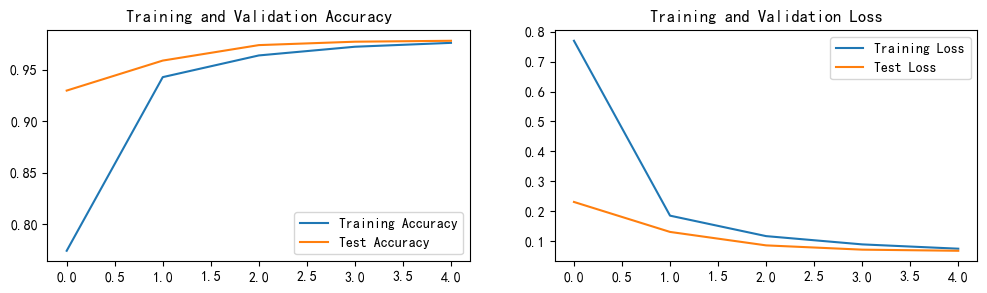

In [31]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()